# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('../../data/datasets/action_images_dataset_original_v1.0')):
    X, y = load_data('../../data/datasets/action_images_dataset_original_v1.0', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 2038, Forehands count: 2412, Other count: 6217, Serve count: 1634
All strokes count: 12301


In [8]:
## Uncomment and run this cell with the desired num_examples count
## if you'd like to work with less data for testing purposes

# num_examples = 500
# X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=num_examples, stratify=y, random_state=42)
# X = X_sampled
# y = y_sampled

# bh_cnt = sum([1 for l in y if l == 'backhand'])
# fh_cnt = sum([1 for l in y if l == 'forehand'])
# other_cnt = sum([1 for l in y if l == 'other'])
# serve_cnt = sum([1 for l in y if l == 'serve'])
# print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
# print(f'All strokes count: {len(y)}')

## Isprobavanje višeslojnog perceptrona (MLP)

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

In [9]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = MLPClassifier(
    hidden_layer_sizes=(100, 150, 125, 75, 100),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    random_state=42,
    shuffle=True
)

clf.fit(X_train, y_train)

MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 150, 125, 75, 100),
              learning_rate='adaptive', max_iter=1000, random_state=42)

In [10]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [11]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.8455284552845529
Precision: 0.8410294193434895
Recall: 0.827333853729949
F1 Score: 0.8329626236264075

Validation set scores:
Accuracy: 0.8012646793134598
Precision: 0.785917644345822
Recall: 0.7700970652730988
F1 Score: 0.775284061561744


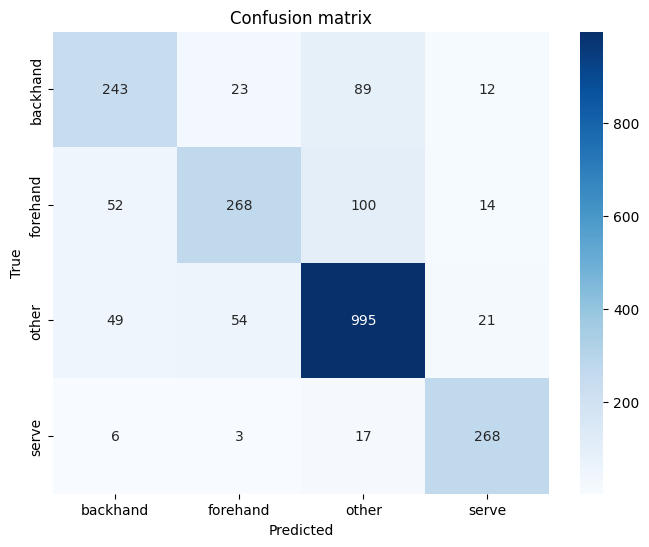

In [12]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.76      0.74      0.75      1467
    forehand       0.83      0.72      0.77      1737
       other       0.86      0.90      0.88      4476
       serve       0.92      0.95      0.93      1176

    accuracy                           0.85      8856
   macro avg       0.84      0.83      0.83      8856
weighted avg       0.84      0.85      0.84      8856



In [14]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.69      0.66      0.68       367
    forehand       0.77      0.62      0.69       434
       other       0.83      0.89      0.86      1119
       serve       0.85      0.91      0.88       294

    accuracy                           0.80      2214
   macro avg       0.79      0.77      0.78      2214
weighted avg       0.80      0.80      0.80      2214



Ovako razvijen model s manje više nasumičnim hiperparametrima se pomalo muči sa generalizacijom. Nastavljamo dalje.

## Pronalaženje najboljih hiperparametara

In [15]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [17]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 150, 100), (75, 100, 200, 150, 100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__learning_rate': ['adaptive']
}

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('mlp', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42, shuffle=True))])

In [18]:
start = time.time()

grid_search = GridSearchCV(grid_model, param_grid=params, scoring='f1_macro', verbose=True, 
                           cv=kf, return_train_score=True)#, n_jobs=50)
grid_search.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Time taken: 00:01:02.91


In [19]:
best_model = grid_search.best_estimator_

print(f"Best score (GridSearchCV): {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7749342012308812
Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.001}

Training set scores:
Accuracy: 0.8436229674796748
Precision: 0.8442160366818017
Recall: 0.8200062525299798
F1 Score: 0.8305774843000147

Validation set scores:
Accuracy: 0.850609756097561
Precision: 0.8510451961348615
Recall: 0.8281465061772757
F1 Score: 0.838155068882904


U ovom slučaju nećemo proširivati pretragu za optimalnim parametrima, jer se u sledećem koraku prelazi na specijalizovane mreže za slike - CNN-ove, tako da proglašavamo gore navedene hiperparametre za najbolje, a gore navedene rezultate proglasiti za konačne za ovaj model. Ugnježdenom unakrsnom validacijom je pronađen model, koji je mnogo bolji od inicijalnog, jer je umnogome smanjen overfit faktor, odnosno rezultati na trening i validacionom skupu su dosta slični. Videćemo kako će se ponašati na kraju na test skupu.

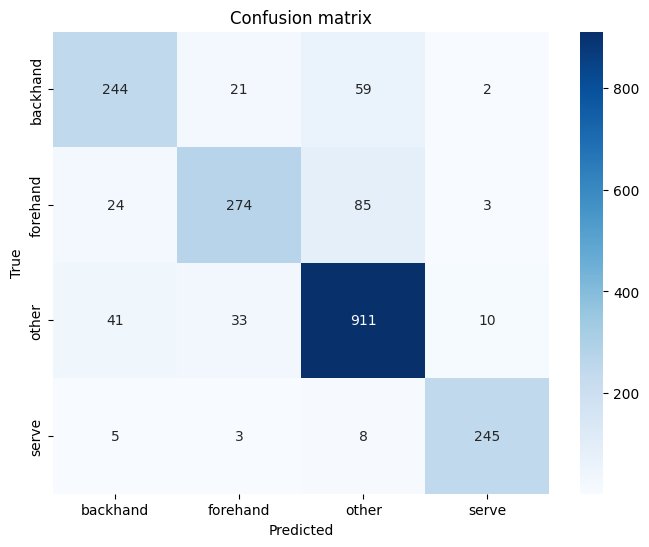

In [20]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.80      0.71      0.75      1304
    forehand       0.81      0.72      0.76      1544
       other       0.85      0.91      0.88      3978
       serve       0.92      0.94      0.93      1046

    accuracy                           0.84      7872
   macro avg       0.84      0.82      0.83      7872
weighted avg       0.84      0.84      0.84      7872



In [22]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.78      0.75      0.76       326
    forehand       0.83      0.71      0.76       386
       other       0.86      0.92      0.89       995
       serve       0.94      0.94      0.94       261

    accuracy                           0.85      1968
   macro avg       0.85      0.83      0.84      1968
weighted avg       0.85      0.85      0.85      1968



Primetimo da je generalizacija modela dobra. Ipak, vidimo da je model prilično dobro naučio da prepozna klase `other` i `serve`, a da se muči s klasama `forehand` i `backhand`, što se donekle može i očekivati, ako se posmatra relativna sličnost ovih udaraca.

## Procena modela na test skupu

In [23]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.8203982121088988
Precision: 0.8196261686232258
Recall: 0.7883453187347016
F1 Score: 0.8022960991355416


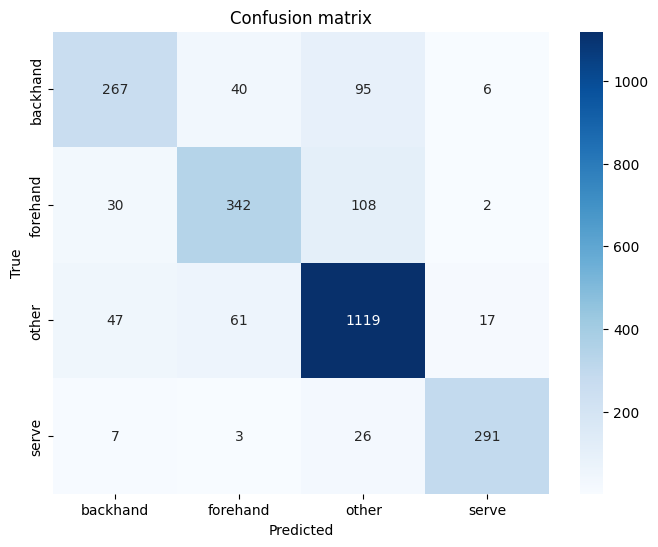

In [24]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.76      0.65      0.70       408
    forehand       0.77      0.71      0.74       482
       other       0.83      0.90      0.86      1244
       serve       0.92      0.89      0.91       327

    accuracy                           0.82      2461
   macro avg       0.82      0.79      0.80      2461
weighted avg       0.82      0.82      0.82      2461



Vidimo da model ipak daje nešto slabije rezultate na test skupu. Ipak, rezultati su prilično prihvatljivi.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [26]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/06_mlp_original_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)